In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


(-2.521732113268817, 2.521732113268815)

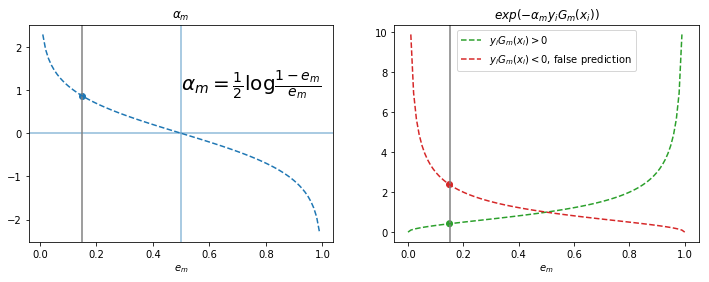

In [2]:
def alpha(error):
    return 0.5 * np.log((1 - error) / error)

e = np.linspace(0, 1, 100)
a = alpha(e)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# axs[0]  alpha_m ~ e_m -------------------------------

ALPHA_COLOR = 'C0'
axs[0].plot(e, a, linestyle='--', color=ALPHA_COLOR)

ylim0 = axs[0].get_ylim()
xlim0 = axs[0].get_xlim()

axs[0].vlines(x=0.5, ymin=ylim0[0], ymax=ylim0[1], color=ALPHA_COLOR, alpha=0.5)
axs[0].hlines(y=0, xmin=xlim0[0], xmax=xlim0[1], color=ALPHA_COLOR, alpha=0.5)
axs[0].text(0.5, 1, r'$\alpha_m = \frac{1}{2}\log\frac{1 - e_m}{e_m}$', fontsize=20)

axs[0].set_ylim(ylim0)
axs[0].set_xlim(xlim0)

axs[0].set_xlabel(r'$e_m$')
axs[0].set_title(r'$\alpha_m$')

# axs[1]  weight-update-factor `exp(-alpha * y * Gm)` ~ e_m -------------------------------

ax = axs[1]

FALSE_PREDICTION_COLOR = 'C3'
RIGHT_PREDICTION_COLOR = 'C2'

ax.plot(e, np.exp(-a), label=r'$y_i G_m(x_i) > 0$', linestyle='--', color=RIGHT_PREDICTION_COLOR)
ax.plot(e, np.exp(a), label=r'$y_i G_m(x_i) < 0$, false prediction', linestyle='--', color=FALSE_PREDICTION_COLOR)
ax.legend()
ax.set_title(r'$exp(-\alpha_m y_iG_m(x_i))$')
ax.set_xlabel(r'$e_m$')


# one example em -------------------------------

em = 0.15

ylim = ax.get_ylim()
ax.vlines(x=em, ymax=ylim[1], ymin=ylim[0], color='grey')
ax.scatter([em, em], [np.exp(-alpha(em)), np.exp(alpha(em))], color=[RIGHT_PREDICTION_COLOR, FALSE_PREDICTION_COLOR])
ax.set_ylim(ylim)


axs[0].vlines(x=em, ymin=ylim0[0], ymax=ylim0[1], color='grey')
axs[0].scatter([em], [alpha(em)], color=ALPHA_COLOR)
axs[0].set_ylim(ylim0)

## Boosting

### basic concepts

**强可学习 (strongly learnable)** 存在一个多项式学习算法能够学习它，且正确率很高  
**弱可学习 (weakly learnable)** 存在一个多项式学习算法能够学习它，正确率仅比随机猜测好

有趣的是，Schapire证明强可学习和弱可学习是等价的

那么问题就成了：如果已经发现了“弱学习算法”，能否将它提升(boost)为“强学习算法”?

1. 如何改变训练数据权值分布
2. 如何组合弱分类器

### AdaBoosting

$y \in {-1, 1} $

初始权值分布 $ w_i = \frac{1}{N} $，得到分类器 $G_0(x)$

```
for m in 1:M:
    训练分类器 G_m
    计算误差 e_m
    计算系数 \alpha_m
    调整权值 w
```

其中

1. 误差为分类错误的样本权值之和：$$e_m = \sum_i w_i I(G_m(x) \neq y_i) $$
2. 系数（弱分类器在组合成强分类器时的权重）$\alpha$ 的计算方式为 $$\alpha_m = \frac{1}{2} \log\frac{1 - e_m}{e_m}$$
3. 权值调整方式为：

$$ w_{i+1} = w_i \frac{1}{Z_m} \exp(-\alpha_m * y_i G_m(x_i)) $$

ie. 

$$ = w_i \frac{1}{Z_m} \exp(-\alpha_m),  \quad \text{样本i分类正确} $$
$$ = w_i \frac{1}{Z_m} \exp(\alpha_m),  \quad \text{样本i分类错误} $$

其中 $Z_m$ 为规范化因子

$$ Z_m = \sum_i w_i \exp(-\alpha_m * y_i G_m(x_i)) $$

最终分类器：弱分类器的线性组合

$$ f(x) = \sum_m \alpha_m G_m(x) $$
$$ G(x) = sign(f(x)) = \sum_m \alpha_m G_m(x)$$

## An 1D Example From *cise.edu.tw*

李航书中一个直观的例子

为了分段函数看起来不重叠，画图采用了手绘风格

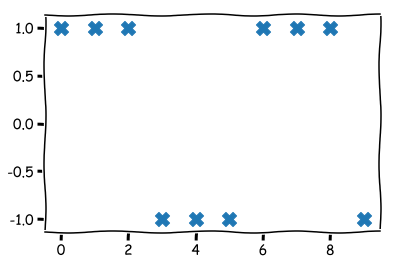

In [3]:
plt.xkcd()

x = np.arange(10)
y = np.array([1,1,1,  -1,-1,-1,  1,1,1,  -1])

fig, ax = plt.subplots()
ax.scatter(x, y, marker='X', s=200)


w1= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

w2= [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]

w3= [0.04545455 0.04545455 0.04545455 0.16666667 0.16666667 0.16666667
 0.10606061 0.10606061 0.10606061 0.04545455] 5


Text(0.5, 1.0, 'f(x)')

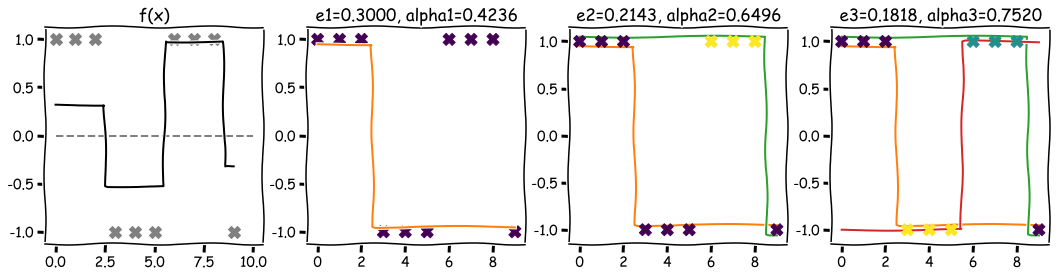

In [4]:
def G_Factory(threshold, reverse=1):
    assert reverse in (-1, 1)
    def G(x):
        return ((x > threshold).astype(int) - 0.5) * 2 * reverse
    return G

def error(y, y_hat, w):
    return np.sum((y != y_hat) * w)

def alpha(error):
    return 0.5 * np.log((1 - error) / error)  # log(odds)

def _to_weight(w):
    assert (w >= 0).all()
    return w / np.sum(w)

def updated_w(w, alpha, y, yhat):
    adjust_factor_v = np.exp(-alpha * y * yhat)  # exp(+-alpha) = exp(0.5 * log(_XX_odds)) = sqrt(_XX_odds)
    return _to_weight(w * adjust_factor_v)


# 画图 ------------------------------------------

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
mpl.rcParams['scatter.marker'] = 'X'
mpl.rcParams['lines.markersize'] = 12
# mpl.rcParams['image.cmap'] = mpl.cm.RdYlGn


dense_x = np.linspace(0, 9, 100)  # 画图用，更密集的x
axs[0].scatter(x, y, color='grey')


# 初始化权值 ------------------
N = 10
w1 = np.repeat(1 / N, N)

# 第一轮 ----------------------
print('\nw1=', w1)

G1 = G_Factory(2.5, -1)  # 根据 G(.) 的具体形式，有不同的实现，这里直接给结果
y1 = G1(x)
e1 = error(y, y1, w1)
alpha1 = alpha(e1)

axs[1].scatter(x, y, c=w1)
axs[1].plot(dense_x, G1(dense_x) * 0.95, color='C1')  # 调整y，避免线条重合
axs[1].set_title('e1={:.4f}, alpha1={:.4f}'.format(e1, alpha1))

w2 = updated_w(w1, alpha1, y, y1)

# 第二轮 ----------------------
print('\nw2=', w2)

G2 = G_Factory(8.5, -1)
y2 = G2(x)
e2 = error(y, y2, w2)
alpha2 = alpha(e2)

_ = axs[2].scatter(x, y, c=w2, zorder=100)
axs[2].plot(dense_x, G1(dense_x) * 0.95, color='C1')
axs[2].plot(dense_x, G2(dense_x) * 1.05, color='C2')
axs[2].set_title('e2={:.4f}, alpha2={:.4f}'.format(e2, alpha2))

w3 = updated_w(w2, alpha2, y, y2)

# 第三轮 ----------------------
print('\nw3=', w3, 5)

G3 = G_Factory(5.5, 1)
y3 = G3(x)
e3 = error(y, y3, w3)
alpha3 = alpha(e3)

axs[3].scatter(x, y, c=w3, zorder=100)
axs[3].plot(dense_x, G1(dense_x) * 0.95, color='C1')
axs[3].plot(dense_x, G2(dense_x) * 1.05, color='C2')
axs[3].plot(dense_x, G3(dense_x), color='C3')
axs[3].set_title('e3={:.4f}, alpha3={:.4f}'.format(e3, alpha3))

# 组合成强分类器 ----------------------

def f(x):
    return alpha1 * G1(x) + alpha2 * G2(x) + alpha3 * G3(x)

def G(x):
    return np.sign(f(x))

axs[0].plot(dense_x, f(dense_x), color='k')
axs[0].hlines(y=0, xmin=0, xmax=10, color='grey', linestyle='--')
#axs[0].plot(dense_x, G(dense_x))
axs[0].set_title('f(x)')


## AdaBoost算法的解释：加法模型 + 指数损失函数 + 前向分步算法

// todo

## 提升树 Boosting tree

以决策树为基函数的提升方法称为**提升树**, 可以表示为决策树的加法模型：

$$ f_M(x) = \sum_{m=1}^M T(x; \Theta_m) $$

算法采用前向分步算法，第$m$步的模型是

$$ f_m(x) = f_{m-1}(x_i) + T(x_i; \Theta_m) $$

策略：经验风险极小化确定下一颗决策树的参数 $\Theta_m$

$$ \min_{\Theta_m} \sum_{i=1}^N L \big( y_i, \quad f_{m-1}(x_i) + T(x_i; \Theta_m) \big) $$


分类问题和回归问题使用的损失函数是不同的：
- 分类：指数损失函数。这是AdaBoost的特殊情况，不再细说。
- 回归：平方误差

### 回归问题的提升树

回归树的表示：将特征空间划分成 $J$ 个互不相交的空间 $R_1, R_2, \dots, R_J$，并在每个空间上确定常量 $c_j$，则回归树可以表示为

$$ T(x; \Theta) = \sum_{j=1}^J c_j \cdot I(x \in R_j) $$

其中 参数 $\Theta = \{ (R_1, c_1), (R_2, c_2), \cdots, (R_J, c_J) \}$ 表示树的区域划分方式和区域上的常量，$J$为回归树的复杂度即叶子节点个数

算法：

$$ f_0(x) = 0 $$

$$ f_m(x) = f_{m-1} + T(x; \Theta_m) $$

$$ f_M(x) = \sum_m T(x; \Theta_m) $$

每一步，求解如下最小化问题：

$$\sum_i L(y_i, f_m(x_i)) $$

当 $L(\cdot)$ 的形式是平方损失函数时，

$$ L = (y - f_m(x))^2 $$
$$ L = \big[y - \big(f_{m-1}(x) + T(x; \Theta_m) \big) \big]^2 $$
$$ L = \big(r_{m-1} - T(x; \Theta_m) \big)^2 $$

即，每一步是拟合上一步的残差

### An 1D Example of Boosting Regression Tree

LiHang Page149

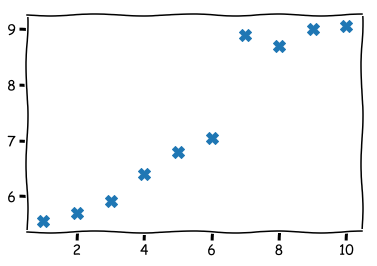

In [5]:
x = np.arange(1, 11)
y = np.array([5.56, 5.70, 5.91, 6.40, 6.80, 7.05, 8.90, 8.70, 9.00, 9.05])

fig, ax = plt.subplots()
ax.scatter(x, y)

In [6]:
class RegressionTree1D(object):
    """一维回归树"""
    
    def __init__(self, y, x):
        self.x = x
        self.y = y
        self.N = len(x)
        self.split = None
        self.c1 = None
        self.c2 = None
        self.sse = None  # Sum of Squared Error
        self.residual = np.zeros(self.N)
        self._fit()
        
    def _fit(self):
        min_sse = np.inf
        split_points = x[:-1] + np.diff(x) / 2
        for s in split_points:
            y1, y2 = self.y[self.x < s], self.y[self.x >= s]
            c1, c2 = np.mean(y1), np.mean(y2)
            sse = np.sum((y1 - c1) ** 2) + np.sum((y2 - c2) ** 2)
            if sse < min_sse:
                min_sse = sse
                self.c1 = c1
                self.c2 = c2
                self.split = s
                self.sse = sse
                self.residual[self.x < s] = y1 - c1
                self.residual[self.x >= s] = y2 - c2
    
    def summary(self):
        txt = 'c1={:.4f} | split={} | c2={:.4f}'.format(self.c1, self.split, self.c2)
        print(txt)
        
    def plot(self, ax):
        ax.scatter(self.x, self.y)
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        ax.vlines(x=self.split, ymin=ylim[0], ymax=ylim[1], linestyle='--')
        ax.hlines(y=self.c1, xmin=xlim[0], xmax=self.split)
        ax.hlines(y=self.c2, xmin=self.split, xmax=xlim[1])
        
    def copy(self):
        """拷贝方法"""
        
        obj = RegressionTree1D(self.x, self.y)
        obj.N = self.N
        obj.split = self.split
        obj.c1 = self.c1
        obj.c2 = self.c2
        obj.sse = self.sse
        obj.residual = self.residual
        return obj
        
        
class BoostingRegressionTree1D(object):
    """一维提升树"""
    
    def __init__(self):
        self.trees = []
        self.x = None
        self.y = None
        
        self.cj = []             # J       [5.63,  5.82,   6.56]
        self.split_points = []   # J-1        [2.5,  *,3.5]
        
    def __add__(self, other_tree):
        """加法运算实现
        
        f_m = f_{m-1} + T_m
        """
        #assert isinstance(other_tree, RegressionTree1D), other_tree.__class__
        obj = self.copy()
        obj.add_new_tree(other_tree)
        return obj
    
    def copy(self):
        """拷贝方法"""
        
        obj = BoostingRegressionTree1D()
        obj.trees = [t.copy() for t in self.trees]
        obj.x = self.x
        obj.y = self.y
        obj.cj = self.cj.copy()
        obj.split_points = self.split_points.copy()
        return obj
    
    def add_new_tree(self, tree):
        """添加树
        
        modify in place ~
        重新计算分割区域、区域值 R_j, c_j
        """
        
        self.trees.append(tree)
        if self.x is None or self.y is None:
            self.x = tree.x
            self.y = tree.y
            self.cj = [tree.c1, tree.c2]                                       #  c_j        len() == J
            self.split_points = [(-np.inf, tree.split), (tree.split, np.inf)]  #  左开右闭区间 len() == J
            print('--> first tree:')
            self.summary()
            return 
        
        idx, a, b = next((i, a, b) for i, (a, b) in enumerate(self.split_points) if a < tree.split <= b)  # 一定找得到，因为初始设置了Inf
        #print('==> idx={}, intervel is ( {}, {} ])'.format(idx, a, b))
            
        # [(-inf, 6.5),  (6.5, inf)]
        # [  6.24,          8.91   ]
        # new split = 3.5
        # idx = 0
            
        if round(tree.split, 2) == round(b, 2):
            print('特殊情况: new_split == b  of  (a, b]')
            # self.split_points 不变
            self.cj[:(idx+1)] += tree.c1
            self.cj[(idx+1):] += tree.c2
        else:
            self.split_points.insert(idx, (a, tree.split))
            self.split_points[idx+1] = (tree.split, b)
            new_cj = list(_ + tree.c1 for _ in self.cj[:(idx+1)]) + list(_ + tree.c2 for _ in self.cj[(idx):])
            self.cj = new_cj
            
        print('--> add new tree. Updated to:')
        self.summary()
        
    def summary(self):
        txt1 = '  ' + ' | '.join('({:02.2f}, {:02.2f}]'.format(a, b) for a, b in self.split_points)
        txt2 = '      '.join('{:04.4f}     '.format(c) for c in self.cj)
        print('split points: ', txt1)
        print('cj          : ', txt2)
            
    def __call__(self, x):
        # todo: 可以优化 用map？
        def f(x):
            return next(self.cj[idx] for idx, (a, b) in enumerate(self.split_points) if a < x <= b)
        return np.array([f(x_) for x_ in x])
    
    def plot(self, ax):
        ax.scatter(self.x, self.y)
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        dense_x = np.linspace(*xlim, 100)
        dense_y = self(dense_x)
        ax.plot(dense_x, dense_y)
        

In [7]:
T1 = RegressionTree1D(y, x)
T1.summary()

T2 = RegressionTree1D(T1.residual, x)
T2.summary()

T3 = RegressionTree1D(T2.residual, x)
T3.summary()

T4 = RegressionTree1D(T3.residual, x)
T4.summary()

T5 = RegressionTree1D(T4.residual, x)
T5.summary()

T6 = RegressionTree1D(T5.residual, x)
T6.summary()


# boosting

f0 = BoostingRegressionTree1D()

f1 = f0 + T1
f2 = f1 + T2
f3 = f2 + T3
f4 = f3 + T4
f5 = f4 + T5
f6 = f5 + T6

c1=6.2367 | split=6.5 | c2=8.9125
c1=-0.5133 | split=3.5 | c2=0.2200
c1=0.1467 | split=6.5 | c2=-0.2200
c1=-0.1608 | split=4.5 | c2=0.1072
c1=0.0715 | split=6.5 | c2=-0.1072
c1=-0.1506 | split=2.5 | c2=0.0377
--> first tree:
split points:    (-inf, 6.50] | (6.50, inf]
cj          :  6.2367           8.9125     
--> add new tree. Updated to:
split points:    (-inf, 3.50] | (3.50, 6.50] | (6.50, inf]
cj          :  5.7233           6.4567           9.1325     
特殊情况: new_split == b  of  (a, b]
--> add new tree. Updated to:
split points:    (-inf, 3.50] | (3.50, 6.50] | (6.50, inf]
cj          :  5.8700           6.6033           8.9125     
--> add new tree. Updated to:
split points:    (-inf, 3.50] | (3.50, 4.50] | (4.50, 6.50] | (6.50, inf]
cj          :  5.7092           6.4425           6.7106           9.0197     
特殊情况: new_split == b  of  (a, b]
--> add new tree. Updated to:
split points:    (-inf, 3.50] | (3.50, 4.50] | (4.50, 6.50] | (6.50, inf]
cj          :  5.7806           6.5

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# y1 = f1(x)
# y2 = f2(x)
# y3 = f3(x)
# y4 = f4(x)
# y5 = f5(x)
# y6 = f6(x)
# y6

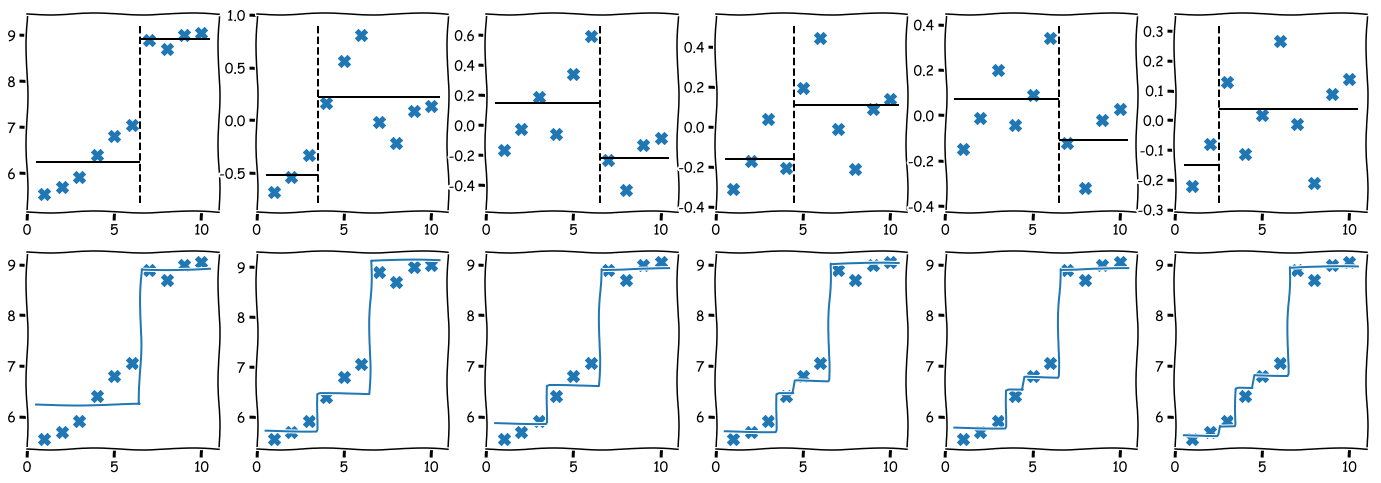

In [9]:
fig, axs = plt.subplots(2, 6, figsize=(6*4, 2*4))

T1.plot(axs[0, 0])
T2.plot(axs[0, 1])
T3.plot(axs[0, 2])
T4.plot(axs[0, 3])
T5.plot(axs[0, 4])
T6.plot(axs[0, 5])

f1.plot(axs[1, 0])
f2.plot(axs[1, 1])
f3.plot(axs[1, 2])
f4.plot(axs[1, 3])
f5.plot(axs[1, 4])
f6.plot(axs[1, 5])

## Python Notes

In [38]:
a = np.zeros(4)
a[[True, False, True, False]] = np.array([99, 100])
a

a[[False, True, False, True]] = np.array([-1, -2])
a

array([ 99.,  -1., 100.,  -2.])